In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band06_wn_1100_1215',
                          'ng_12',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_12',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_all1',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_none',
                          'crd_a3d1611',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band06_wn_1100_1215',
                          'ng_12',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_12',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_all1',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_none',
                          'crd_a3d1611',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1100

nband = 1215

nv = 200

dv = 0.005

tsfc = 294.0

ng = 12

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 12 /)

data wgt
     &     /12*1/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 1e-24

include 'mls75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

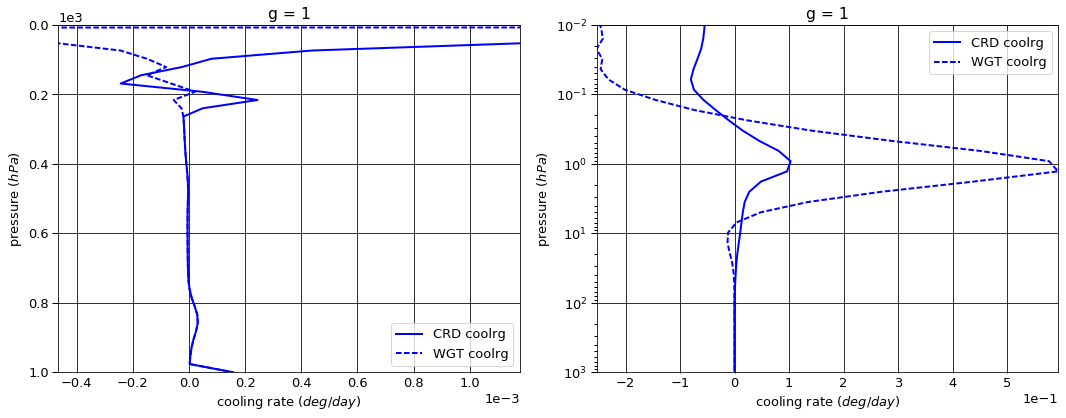

# Figure: cooling rate g-group 2

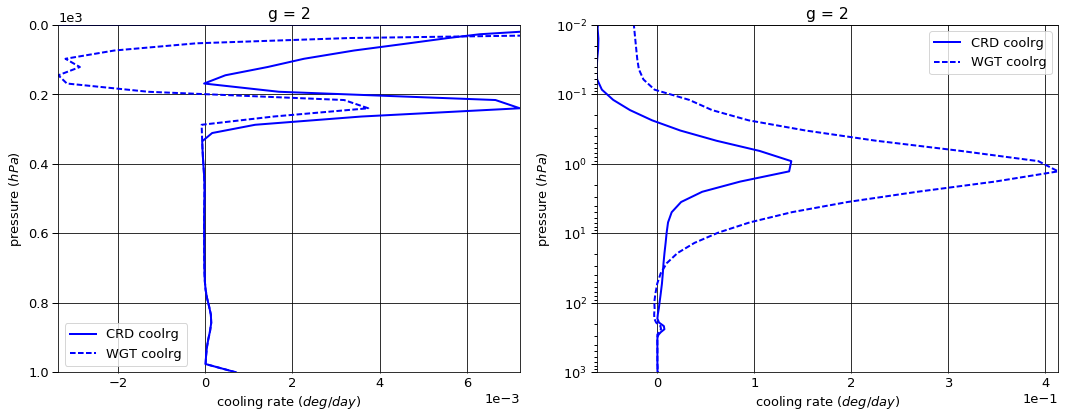

# Figure: cooling rate g-group 3

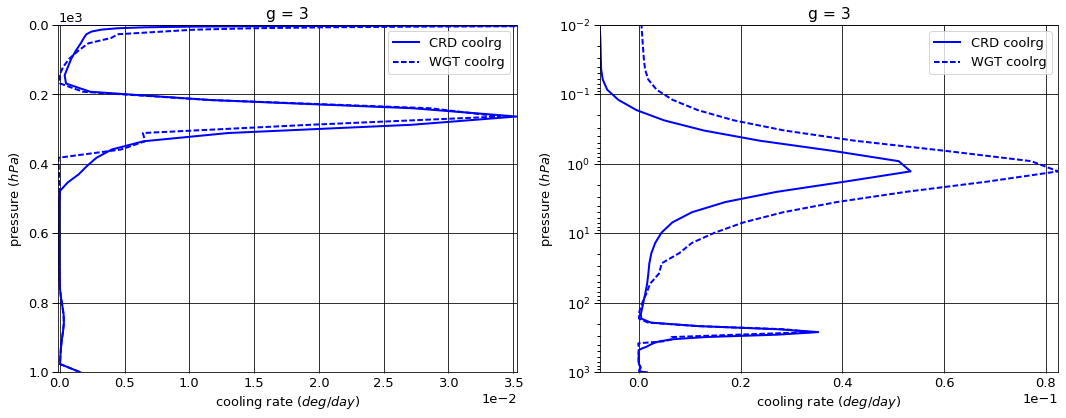

# Figure: cooling rate g-group 4

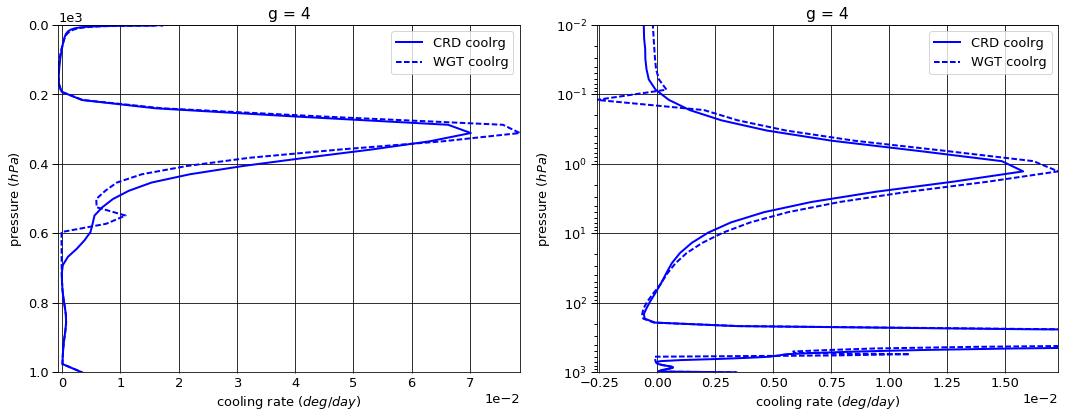

# Figure: cooling rate g-group 5

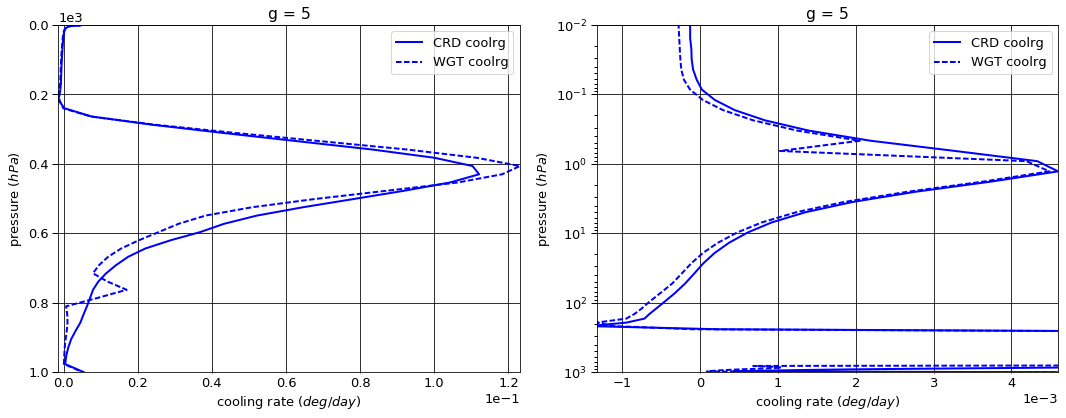

# Figure: cooling rate g-group 6

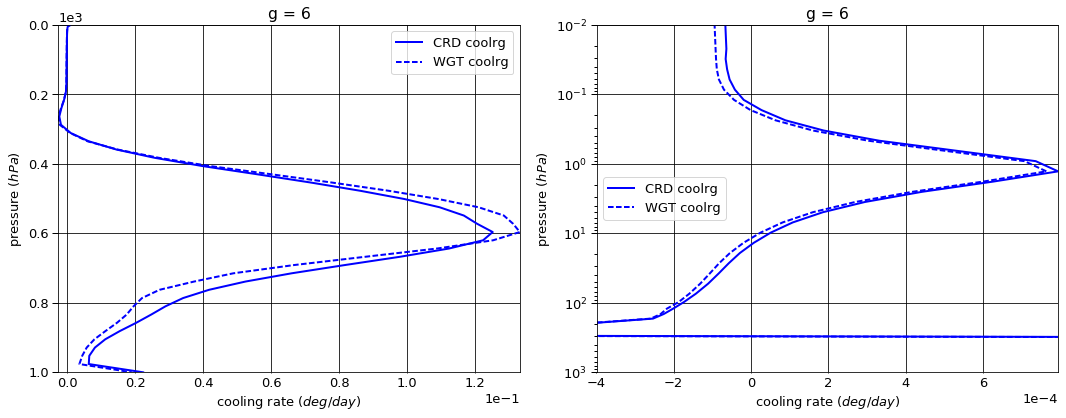

# Figure: cooling rate g-group 7

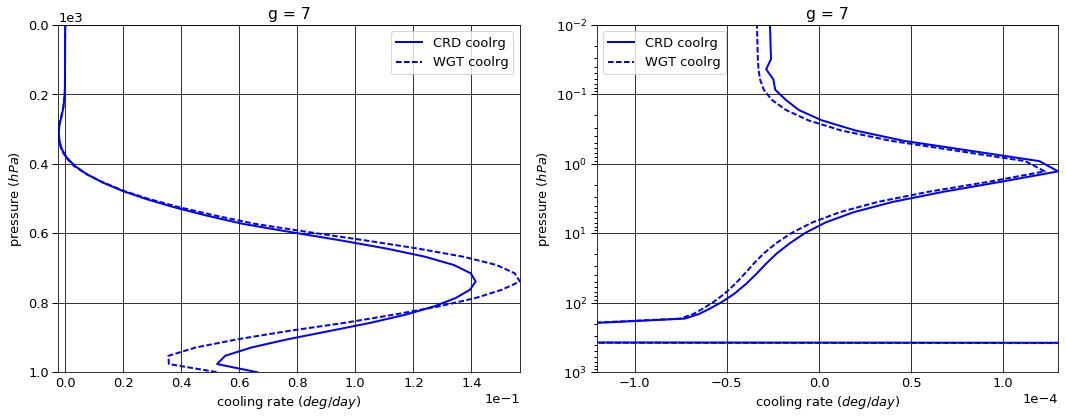

# Figure: cooling rate g-group 8

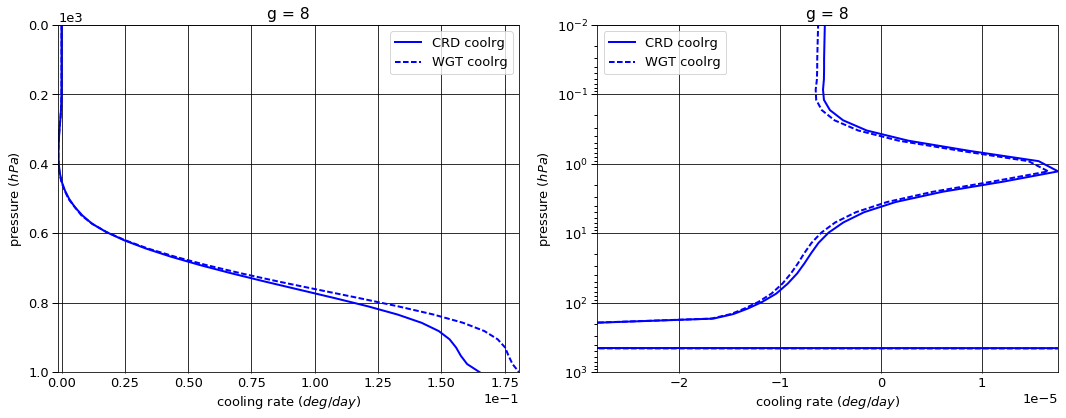

# Figure: cooling rate g-group 9

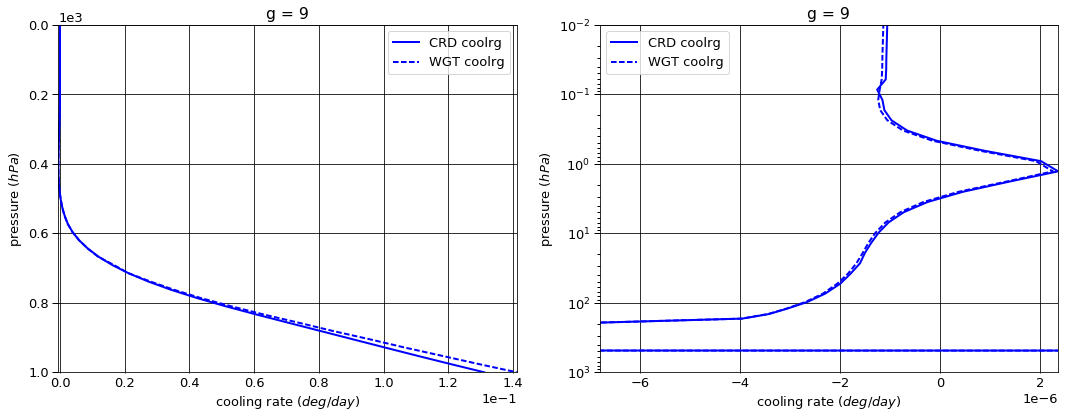

# Figure: cooling rate g-group 10

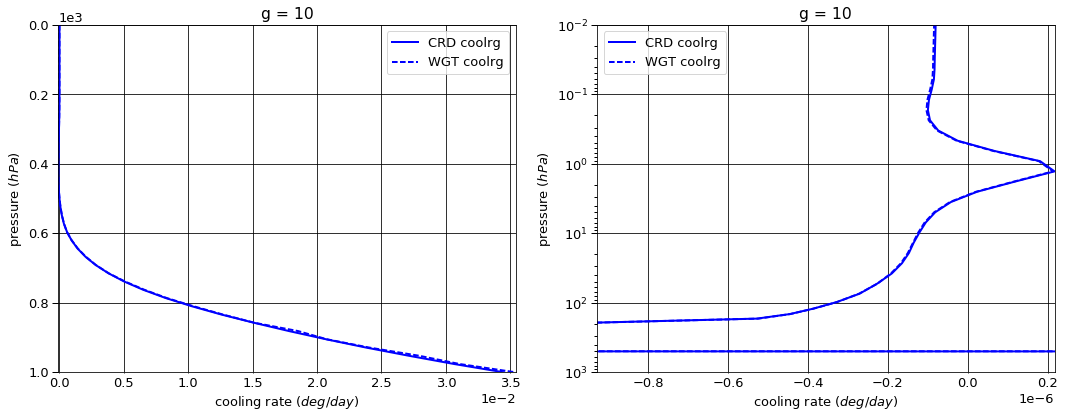

# Figure: cooling rate g-group 11

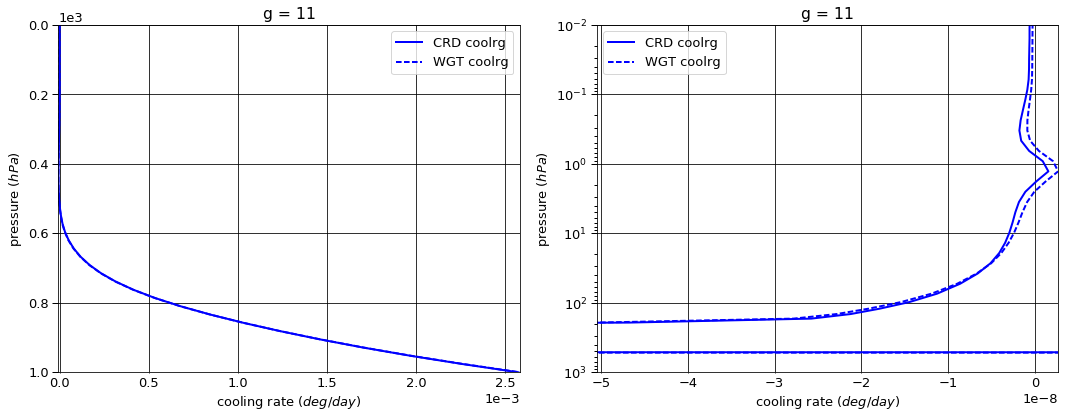

# Figure: cooling rate g-group 12

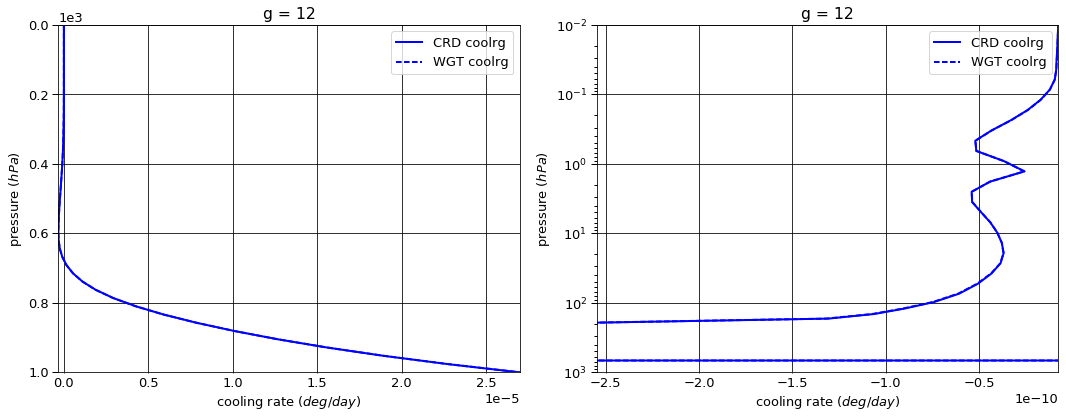

# Figure: cooling rate g-group total

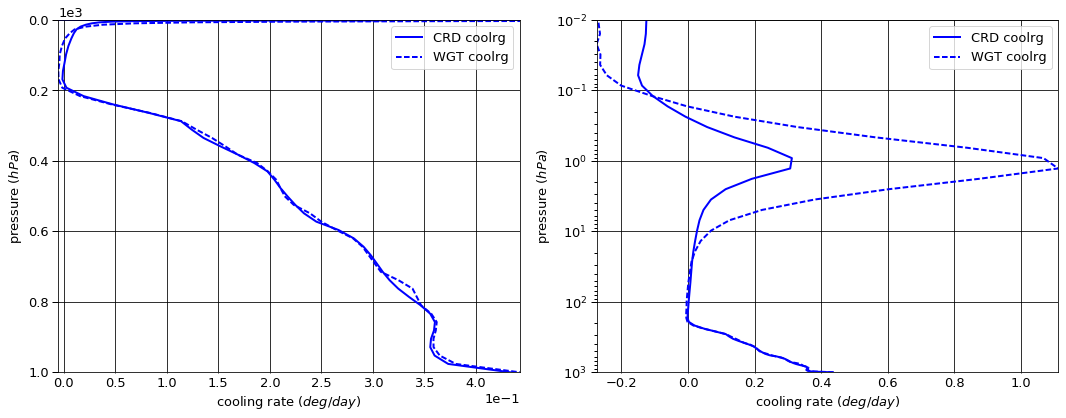

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.049506   0.000000  -0.049506
   1013.0   76     -0.378174   0.377731  -0.000443
2  0.0      1      -0.157338   0.000000  -0.157338
   1013.0   76     -1.705689   1.703710  -0.001979
3  0.0      1      -0.432158   0.000000  -0.432158
   1013.0   76     -3.877285   3.872809  -0.004476
4  0.0      1      -1.362687   0.000000  -1.362687
   1013.0   76     -8.266514   8.256978  -0.009536
5  0.0      1      -3.277131   0.000000  -3.277131
   1013.0   76    -12.834877  12.819808  -0.015069
6  0.0      1      -4.617796   0.000000  -4.617796
   1013.0   76    -11.039898  10.977531  -0.062367
7  0.0      1      -6.175361   0.000000  -6.175361
   1013.0   76     -9.807338   9.436833  -0.370505
8  0.0      1      -8.588907   0.000000  -8.588907
   1013.0   76    -10.169215   6.883301  -3.285914
9  0.0      1     -11.612818   0.000000 -11.612818
   1013.0   76    -12.172286   3.347083  -8.825203
10 0.0      1     -10.216979   0.000000 -10.216979
   1013.0   76    -10.321950   0.735757  -9.586194
11 0.0      1      -2.315486   0.000000  -2.315486
   1013.0   76     -2.322760   0.051450  -2.271310
12 0.0      1      -0.088467   0.000000  -0.088467
   1013.0   76     -0.088574   0.000470  -0.088104


WGT


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.127092   0.000000  -0.127092
   1013.0   76     -0.378174   0.377731  -0.000443
2  0.0      1      -0.242948   0.000000  -0.242948
   1013.0   76     -1.705689   1.703710  -0.001979
3  0.0      1      -0.406714   0.000000  -0.406714
   1013.0   76     -3.877285   3.872809  -0.004476
4  0.0      1      -1.290315   0.000000  -1.290315
   1013.0   76     -8.266514   8.256978  -0.009536
5  0.0      1      -3.134140   0.000000  -3.134140
   1013.0   76    -12.834877  12.820273  -0.014605
6  0.0      1      -4.458545   0.000000  -4.458545
   1013.0   76    -11.039898  10.990084  -0.049814
7  0.0      1      -6.001796   0.000000  -6.001796
   1013.0   76     -9.807338   9.607755  -0.199583
8  0.0      1      -8.497644   0.000000  -8.497644
   1013.0   76    -10.169215   7.485640  -2.683575
9  0.0      1     -11.601743   0.000000 -11.601743
   1013.0   76    -12.172286   3.503771  -8.668515
10 0.0      1     -10.217617   0.000000 -10.217617
   1013.0   76    -10.321950   0.745773  -9.576178
11 0.0      1      -2.315402   0.000000  -2.315402
   1013.0   76     -2.322760   0.051530  -2.271231
12 0.0      1      -0.088467   0.000000  -0.088467
   1013.0   76     -0.088574   0.000470  -0.088104


WGT - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -7.758607e-02  0.000000e+00 -7.758607e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1     -8.560968e-02  0.000000e+00 -8.560968e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1      2.544396e-02  0.000000e+00  2.544396e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      7.237170e-02  0.000000e+00  7.237170e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      1.429913e-01  0.000000e+00  1.429913e-01
   1013.0   76     0.000000e+00  4.650000e-04  4.647590e-04
6  0.0      1      1.592513e-01  0.000000e+00  1.592513e-01
   1013.0   76     0.000000e+00  1.255300e-02  1.255231e-02
7  0.0      1      1.735641e-01  0.000000e+00  1.735641e-01
   1013.0   76     0.000000e+00  1.709221e-01  1.709221e-01
8  0.0      1      9.126350e-02  0.000000e+00  9.126350e-02
   1013.0   76     0.000000e+00  6.023392e-01  6.023391e-01
9  0.0      1      1.107500e-02  0.000000e+00  1.107500e-02
   1013.0   76     0.000000e+00  1.566882e-01  1.566883e-01
10 0.0      1     -6.380000e-04  0.000000e+00 -6.380000e-04
   1013.0   76     0.000000e+00  1.001615e-02  1.001610e-02
11 0.0      1      8.420000e-05  0.000000e+00  8.420000e-05
   1013.0   76     0.000000e+00  7.975200e-05  7.970000e-05
12 0.0      1      1.910000e-07  0.000000e+00  1.910000e-07
   1013.0   76     0.000000e+00  4.143000e-07  4.140000e-07

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.530065e-02
   1001.112500 75     1.578805e-04
2  0.000312    1     -6.581439e-02
   1001.112500 75     7.059386e-04
3  0.000312    1     -8.210854e-03
   1001.112500 75     1.596658e-03
4  0.000312    1     -7.547748e-04
   1001.112500 75     3.401380e-03
5  0.000312    1     -1.839265e-04
   1001.112500 75     5.511739e-03
6  0.000312    1     -7.355677e-05
   1001.112500 75     2.234071e-02
7  0.000312    1     -2.747100e-05
   1001.112500 75     6.627546e-02
8  0.000312    1     -5.337575e-06
   1001.112500 75     1.652382e-01
9  0.000312    1     -1.009333e-06
   1001.112500 75     1.311490e-01
10 0.000312    1     -7.481079e-08
   1001.112500 75     3.448884e-02
11 0.000312    1     -5.103465e-10
   1001.112500 75     2.573676e-03
12 0.000312    1     -5.628821e-12
   1001.112500 75     2.696538e-05


WGT


coolrg
g  pressure    layer              
1  0.000312    1     -2.685476e-01
   1001.112500 75     1.578805e-04
2  0.000312    1     -3.161685e-02
   1001.112500 75     7.059386e-04
3  0.000312    1     -4.070036e-04
   1001.112500 75     1.596658e-03
4  0.000312    1     -3.736653e-04
   1001.112500 75     3.401380e-03
5  0.000312    1     -3.186510e-04
   1001.112500 75     5.210176e-03
6  0.000312    1     -1.009903e-04
   1001.112500 75     1.899702e-02
7  0.000312    1     -3.434228e-05
   1001.112500 75     5.258567e-02
8  0.000312    1     -5.965962e-06
   1001.112500 75     1.807725e-01
9  0.000312    1     -1.084937e-06
   1001.112500 75     1.411675e-01
10 0.000312    1     -7.862938e-08
   1001.112500 75     3.541867e-02
11 0.000312    1     -2.281549e-10
   1001.112500 75     2.581814e-03
12 0.000312    1     -6.004076e-12
   1001.112500 75     2.700677e-05


WGT - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.032469e-01
   1001.112500 75     0.000000e+00
2  0.000312    1      3.419754e-02
   1001.112500 75     0.000000e+00
3  0.000312    1      7.803850e-03
   1001.112500 75     0.000000e+00
4  0.000312    1      3.811095e-04
   1001.112500 75     0.000000e+00
5  0.000312    1     -1.347245e-04
   1001.112500 75    -3.015634e-04
6  0.000312    1     -2.743353e-05
   1001.112500 75    -3.343688e-03
7  0.000312    1     -6.871280e-06
   1001.112500 75    -1.368979e-02
8  0.000312    1     -6.283866e-07
   1001.112500 75     1.553429e-02
9  0.000312    1     -7.560330e-08
   1001.112500 75     1.001856e-02
10 0.000312    1     -3.818592e-09
   1001.112500 75     9.298330e-04
11 0.000312    1      2.821916e-10
   1001.112500 75     8.138400e-06
12 0.000312    1     -3.752547e-13
   1001.112500 75     4.138500e-08

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-48.894635,0.000000,-48.894635
1013.0,76,-82.984560,58.463459,-24.521102



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-48.382423,0.000000,-48.382423
1013.0,76,-82.984560,59.416523,-23.568039



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.512211,0.000000,0.512211
1013.0,76,0.000000,0.953064,0.953063


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.140372
1001.112500,75,0.433466



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.301406
1001.112500,75,0.442622



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.161034
1001.112500,75,0.009156


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.005107,0.003831
2,0.022630,0.017521
3,0.050930,0.040137
4,0.109926,0.085778
5,0.167267,0.136052
6,0.133128,0.124744
7,0.114313,0.118958
8,0.115078,0.130385
9,0.120321,0.165010


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.756374e-19
2,6.642152e-20
3,1.174489e-20
4,2.076772e-21
5,3.672221e-22
6,6.493349e-23
7,1.148177e-23
8,2.030246e-24
9,3.589953e-25


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [12]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.756374e-19,NaN,0.005107,0.003831,0.005107,0.003831,600.0
2,6.642152e-20,0.176824,0.022630,0.017521,0.027737,0.021352,600.0
3,1.174489e-20,0.176824,0.050930,0.040137,0.078667,0.061489,600.0
4,2.076772e-21,0.176824,0.109926,0.085778,0.188593,0.147266,600.0
5,3.672221e-22,0.176824,0.167267,0.136052,0.355860,0.283318,600.0
6,6.493349e-23,0.176824,0.133128,0.124744,0.488988,0.408062,600.0
7,1.148177e-23,0.176824,0.114313,0.118958,0.603300,0.527020,600.0
8,2.030246e-24,0.176824,0.115078,0.130385,0.718379,0.657405,600.0
9,3.589953e-25,0.176824,0.120321,0.165010,0.838700,0.822416,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                     
1     1      0.000312  1.298758e-18  3.596832e-20  36.108382
      2      0.000312  9.012714e-20  2.768620e-21  32.553089
      3      0.000312  4.370359e-21  2.384415e-22  18.328854
      4      0.000312  4.372010e-22  3.503631e-23  12.478509
      5      0.000312  8.036018e-23  6.876482e-24  11.686235
      6      0.000312  1.646312e-23  1.489128e-24  11.055543
      7      0.000312  3.709873e-24  2.367109e-25  15.672593
      8      0.000312  4.150836e-25  3.947974e-26  10.513839
      9      0.000312  5.286848e-26  5.423581e-27   9.747892
      10     0.000312  4.273753e-27  5.717935e-28   7.474295
      11     0.000312  5.161423e-29  2.620305e-29   1.969779
      12     0.000312  2.982664e-29  1.498498e-29   1.990436
2     1      0.000750  1.298628e-18  3.599510e-20  36.077900
      2      0.000750  9.023020e-20  2.771189e-21  32.560107
      3      0.000750  4.384762e-21  2.387825e-22  18.362993
      4      0.000750  4.384136e-22  3.509746e-23  12.491321
      5      0.000750  8.057009e-23  6.887637e-24  11.697783
      6      0.000750  1.649834e-23  1.491763e-24  11.059628
      7      0.000750  3.720151e-24  2.373410e-25  15.674288
      8      0.000750  4.172302e-25  3.960834e-26  10.533900
      9      0.000750  5.313766e-26  5.443046e-27   9.762486
      10     0.000750  4.300099e-27  5.741572e-28   7.489410
      11     0.000750  5.240454e-29  2.646430e-29   1.980198
      12     0.000750  3.023414e-29  1.513910e-29   1.997090
3     1      0.001052  1.298342e-18  3.603993e-20  36.025097
      2      0.001052  9.044870e-20  2.775760e-21  32.585203
      3      0.001052  4.415412e-21  2.394398e-22  18.440590
      4      0.001052  4.409965e-22  3.521834e-23  12.521785
      5      0.001052  8.101754e-23  6.909669e-24  11.725242
      6      0.001052  1.657359e-23  1.497066e-24  11.070708
      7      0.001052  3.742046e-24  2.386262e-25  15.681620
      8      0.001052  4.218153e-25  3.987543e-26  10.578325
      9      0.001052  5.371382e-26  5.483422e-27   9.795676
      10     0.001052  4.356645e-27  5.790621e-28   7.523622
      11     0.001052  5.410006e-29  2.700399e-29   2.003410
      12     0.001052  3.111687e-29  1.546962e-29   2.011483
4     1      0.001476  1.298030e-18  3.608973e-20  35.966750
      2      0.001476  9.067978e-20  2.780776e-21  32.609520
      3      0.001476  4.448031e-21  2.401479e-22  18.522048
      4      0.001476  4.437529e-22  3.534782e-23  12.553897
      5      0.001476  8.149496e-23  6.933325e-24  11.754095
      6      0.001476  1.665425e-23  1.502751e-24  11.082508
      7      0.001476  3.765380e-24  2.400034e-25  15.688863
      8      0.001476  4.267194e-25  4.016115e-26  10.625177
      9      0.001476  5.433182e-26  5.526631e-27   9.830913
      10     0.001476  4.417575e-27  5.843091e-28   7.560340
      11     0.001476  5.595672e-29  2.758808e-29   2.028293
      12     0.001476  3.208134e-29  1.582784e-29   2.026893
5     1      0.002070  1.297710e-18  3.614321e-20  35.904666
      2      0.002070  9.091084e-20  2.786074e-21  32.630447
      3      0.002070  4.480862e-21  2.408768e-22  18.602293
      4      0.002070  4.465351e-22  3.547985e-23  12.585599
      5      0.002070  8.197677e-23  6.957516e-24  11.782476
      6      0.002070  1.673607e-23  1.508545e-24  11.094181
      7      0.002070  3.788901e-24  2.414045e-25  15.695241
      8      0.002070  4.316807e-25  4.045090e-26  10.671720
      9      0.002070  5.495890e-26  5.570473e-27   9.866109
      10     0.002070  4.479697e-27  5.896315e-28   7.597452
      11     0.002070  5.788283e-29  2.818847e-29   2.053422
      12     0.002070  3.307877e-29  1.619537e-29   2.042483
6     1      0.002904  1.297381e-18  3.620161e-20  35.837654
      2      0.002904  9.114167e-20  2.791745e-21  32.646846
      3      0.002904  4.513877e-21  2.416334e-22  18.680687
      4      0.002904  4.493414e-22  3.561532e-2

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
